In [46]:
import numpy as np 
import pandas as pd

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer



In [48]:
test_data = pd.read_csv("/content/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

In [49]:

train_data = pd.read_csv("/content/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("/content/val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [50]:
train_data.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [51]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


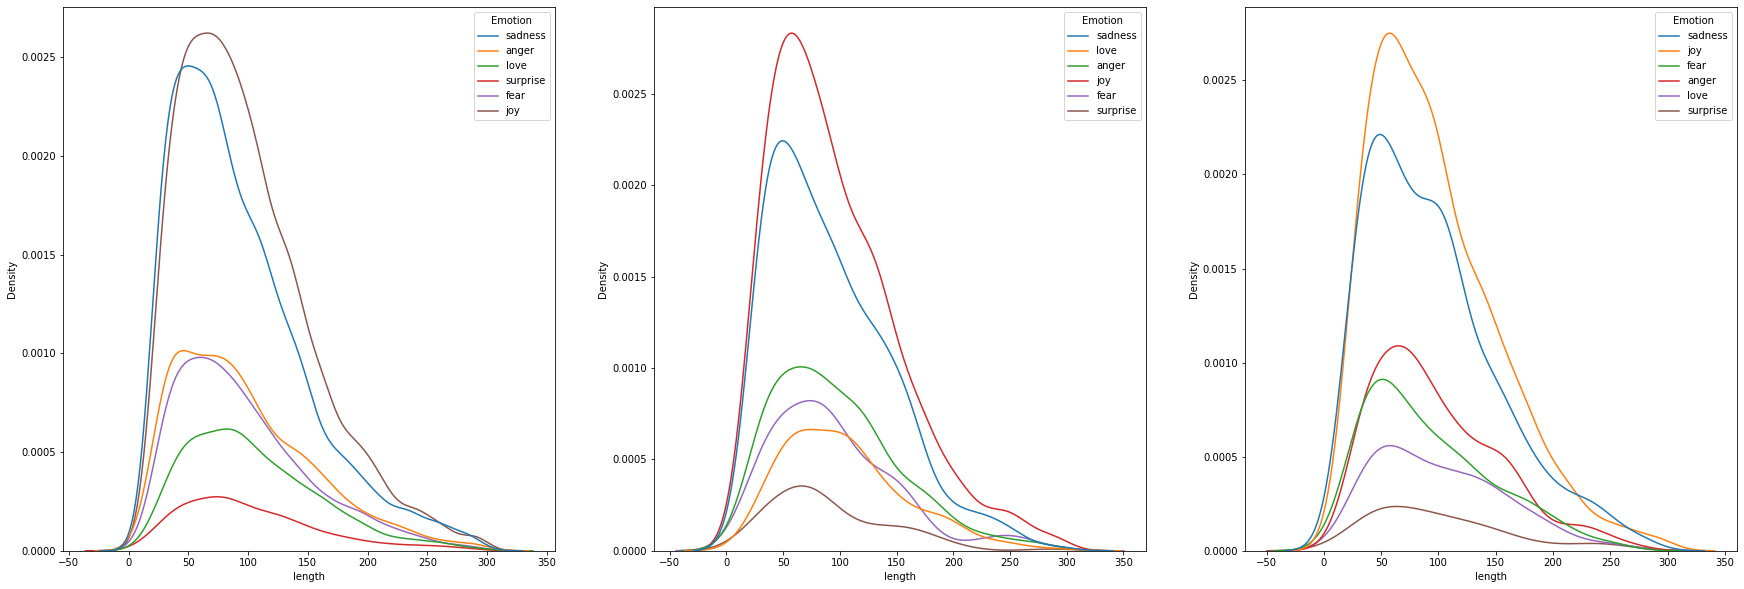

In [53]:
all_data = {'Train Data': train_data, 'Validation Data': validation_data, 'Test Data': test_data}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Comment']]
    sns.kdeplot(data=df2,x='length',hue='Emotion', ax=ax[i])
plt.show()

In [54]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [55]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

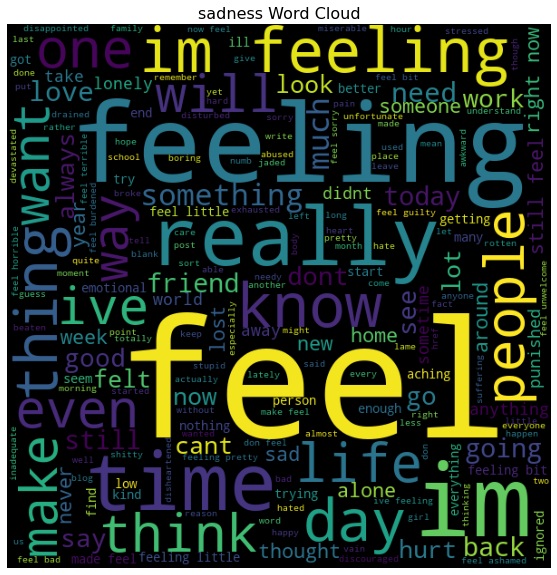

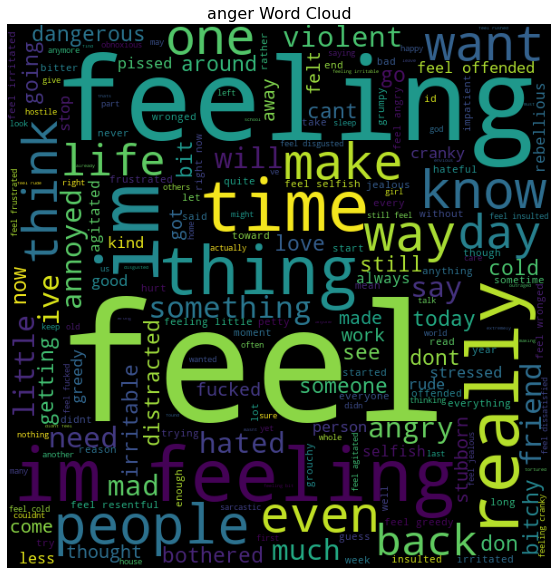

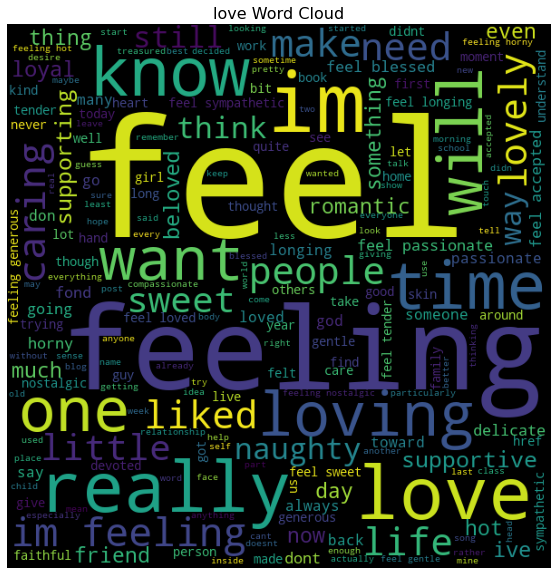

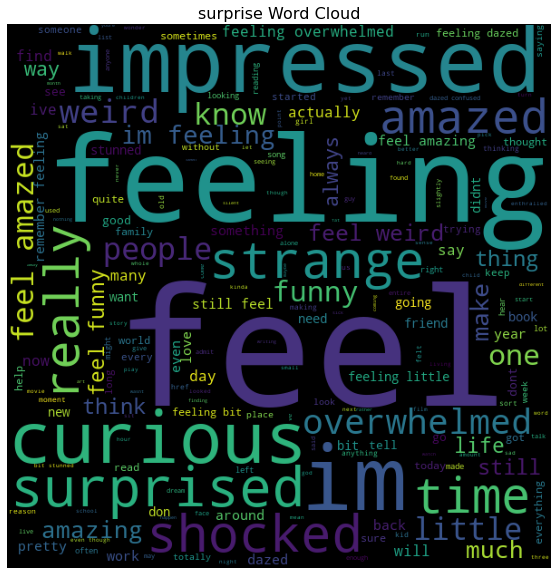

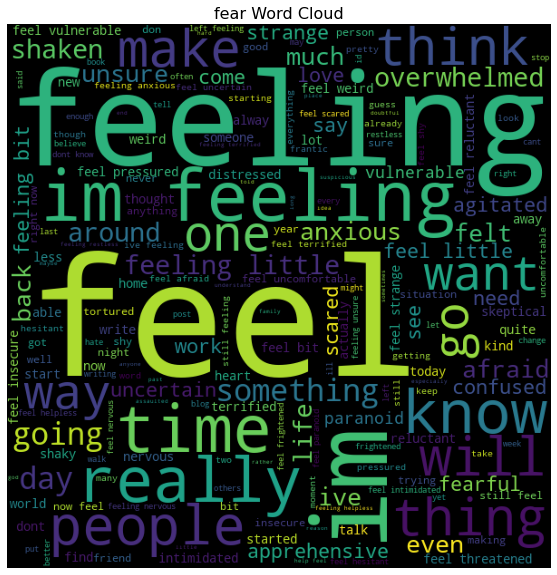

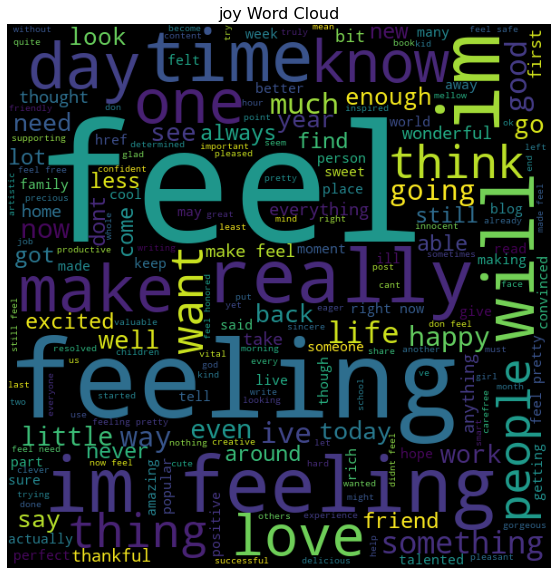

In [56]:
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [57]:
#Preprocessing
#Label Encoding
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

In [58]:
train_data.head(2)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108


In [59]:
#Removing unrelevent stopwords and chars
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
max_len=train_data['length'].max()
max_len

300

In [61]:
max_len=train_data['length'].max()
max_len

300

In [62]:
vocabSize = 11000

In [63]:
from tensorflow.keras.preprocessing.text import one_hot
def text_cleaning(df, column):
    """Removing unrelevent chars, Stemming and padding"""
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [64]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")



(16000, 300)
(2000, 300)
(2000, 300)


In [65]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

In [66]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

Model building

In [68]:
#After number of tries with higher/lower dim, and adding layers, this model was the most efficient:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [69]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 150)          1650000   
                                                                 
 dropout_6 (Dropout)         (None, 300, 150)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                

In [70]:
callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [71]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 196s 774ms/step - loss: 1.4900 - accuracy: 0.4073 - val_loss: 0.9611 - val_accuracy: 0.6775
Epoch 2/10
250/250 [==============================] - 190s 762ms/step - loss: 0.5755 - accuracy: 0.8151 - val_loss: 0.3910 - val_accuracy: 0.8675
Epoch 3/10
250/250 [==============================] - 189s 757ms/step - loss: 0.2899 - accuracy: 0.9070 - val_loss: 0.3623 - val_accuracy: 0.8850
Epoch 4/10
250/250 [==============================] - 189s 757ms/step - loss: 0.2063 - accuracy: 0.9319 - val_loss: 0.3354 - val_accuracy: 0.8905
Epoch 5/10
250/250 [==============================] - 189s 757ms/step - loss: 0.1553 - accuracy: 0.9484 - val_loss: 0.3391 - val_accuracy: 0.8900
Epoch 6/10
250/250 [==============================] - 192s 769ms/step - loss: 0.1209 - accuracy: 0.9579 - val_loss: 0.3562 - val_accuracy: 0.8895
Epoch 7/10
250/250 [==============================] - 189s 758ms/step - loss: 0.1052 - accuracy: 0.9635 - val_loss: 0.3676 -

In [72]:
model.evaluate(x_val,y_val,verbose=1)

63/63 [==============================] - 6s 89ms/step - loss: 0.3354 - accuracy: 0.8905


[0.3354199528694153, 0.890500009059906]

In [73]:
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 6s 87ms/step - loss: 0.3415 - accuracy: 0.8790


[0.34150752425193787, 0.8790000081062317]

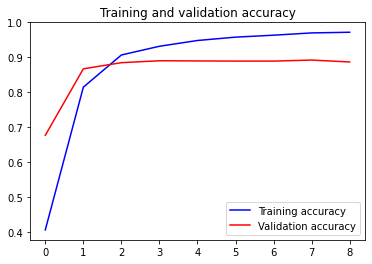

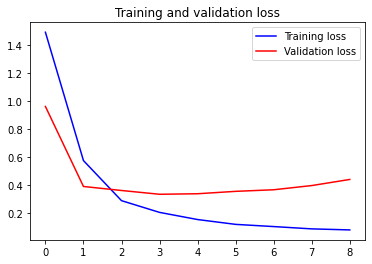

In [74]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()